## In this notebook the FNet optimization results are validating against train and heldout data

In [1]:
import random
import pathlib
import sys
import yaml
from collections import defaultdict

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.artifacts
from optuna.visualization import plot_param_importances, plot_optimization_history
import joblib

## Read config

In [2]:
with open(pathlib.Path('.').absolute().parent.parent / "config.yml", "r") as file:
    config = yaml.safe_load(file)

## Import virtual_stain_flow software 

In [3]:
sys.path.append(config['paths']['software_path'])
print(str(pathlib.Path('.').absolute().parent.parent))

## Dataset
from virtual_stain_flow.datasets.PatchDataset import PatchDataset

## FNet training
from virtual_stain_flow.models.fnet import FNet

from virtual_stain_flow.transforms.MinMaxNormalize import MinMaxNormalize
from virtual_stain_flow.transforms.PixelDepthTransform import PixelDepthTransform

## Metrics
from virtual_stain_flow.metrics.PSNR import PSNR
from virtual_stain_flow.metrics.SSIM import SSIM

## Visualization software
from virtual_stain_flow.evaluation.visualization_utils import plot_predictions_grid_from_eval
from virtual_stain_flow.evaluation.evaluation_utils import evaluate_per_image_metric
from virtual_stain_flow.evaluation.predict_utils import predict_image

/home/weishanli/Waylab/pediatric_cancer_atlas_analysis


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Define paths and other train parameters

In [4]:
## Loaddata for train and heldout set
LOADDATA_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
assert LOADDATA_FILE_PATH.exists(), f"File not found: {LOADDATA_FILE_PATH}"

LOADDATA_HELDOUT_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_heldout.csv'
assert LOADDATA_HELDOUT_FILE_PATH.exists(), f"Directory not found: {LOADDATA_HELDOUT_FILE_PATH}"

## Corresponding sc features directory containing cell coordiantes used for patch generation
SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])
assert SC_FEATURES_DIR.exists(), f"Directory not found: {SC_FEATURES_DIR}"

## Optimization Output Saved under these directories
MLFLOW_DIR = pathlib.Path('.').absolute() / 'optuna_mlflow'
assert MLFLOW_DIR.exists(), f"Mlflow directory not found: {MLFLOW_DIR}"

OPTUNA_JOBLIB_DIR = pathlib.Path('.').absolute() / 'optuna_joblib'
assert OPTUNA_JOBLIB_DIR.exists(), f"Optuna joblib directory not found: {OPTUNA_JOBLIB_DIR}"

## Validation Output Path
VALIDATION_OUTPUT_DIR = pathlib.Path('.').absolute() / 'validation'
VALIDATION_OUTPUT_DIR.mkdir(exist_ok=True)
VALIDATION_INTERMEDIATE_DIR = VALIDATION_OUTPUT_DIR / 'intermediate'
VALIDATION_INTERMEDIATE_DIR.mkdir(exist_ok=True)
VALIDATION_PLOTS_DIR = VALIDATION_OUTPUT_DIR / 'plots'
VALIDATION_PLOTS_DIR.mkdir(exist_ok=True)

## Channels for input and target are read from config
INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']

In [5]:
## Patch size definition
PATCH_SIZE = 256

CONFLUENCE_GROUPS = ['high_confluence', 'low_confluence']

## Define Discrete Conditions to Evaluate

In [6]:
# Relevant columns in loaddata
SITE_COLUMN = 'Metadata_Site'
WELL_COLUMN = 'Metadata_Well'
PLATE_COLUMN = 'Metadata_Plate'

PLATEMAP_COLUMN = 'platemap_file'
CELL_LINE_COLUMN = 'cell_line'
SEEDING_DENSITY_COLUMN = 'seeding_density'

# Sites are uniquely identified by the combination of these columns
UNIQUE_IDENTIFIERS = [SITE_COLUMN, WELL_COLUMN, PLATE_COLUMN]
# Conditions are uniquely identified by the combination of these columns
CONDITION_IDENTIFIERS =  [CELL_LINE_COLUMN, SEEDING_DENSITY_COLUMN, PLATEMAP_COLUMN]

In [7]:
mlflow.set_tracking_uri(MLFLOW_DIR / 'mlruns')

mlflow_results = {}
optuna_results = defaultdict(dict)

for confluence_group_name in CONFLUENCE_GROUPS:
    ## Access relevant optimization result and logs by confluence
    experiment_name = f'FNet_optimize_{confluence_group_name}'
    experiment = mlflow.get_experiment_by_name(experiment_name)
    mlflow_results[confluence_group_name] = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    for channel_name in TARGET_CHANNEL_NAMES:
        optuna_study_path = OPTUNA_JOBLIB_DIR / f"FNet_optimize_{channel_name}_{confluence_group_name}.joblib"
        study = joblib.load(optuna_study_path)
        optuna_results[confluence_group_name][channel_name] = study

        print(f"Optuna study {channel_name} {confluence_group_name}:")
        plot_param_importances(study).show()
        plot_optimization_history(study).show()

Optuna study OrigDNA high_confluence:


Optuna study OrigER high_confluence:


Optuna study OrigAGP high_confluence:


Optuna study OrigMito high_confluence:


Optuna study OrigRNA high_confluence:


Optuna study OrigDNA low_confluence:


Optuna study OrigER low_confluence:


Optuna study OrigAGP low_confluence:


Optuna study OrigMito low_confluence:


Optuna study OrigRNA low_confluence:


## Concatenate datasplits into a single dataframe to streamline evaluation

In [8]:
## Concat all datasplits
loaddata_df_all = pd.DataFrame()
for datasplit, file in zip(
    ['train', 'heldout'], 
    [LOADDATA_FILE_PATH, LOADDATA_HELDOUT_FILE_PATH]):
    loaddata_df = pd.read_csv(file, index_col=0)
    loaddata_df['datasplit'] = datasplit
    loaddata_df_all = pd.concat([loaddata_df_all, loaddata_df])
loaddata_df_all.head()

,Metadata_Plate,time_point,platemap_file,cell_line,row,column,Metadata_Well,seeding_density,FileName_OrigBrightfield,PathName_OrigBrightfield,...,Metadata_ChannelID,Metadata_Col,Metadata_FieldID,Metadata_PlaneID,Metadata_PositionX,Metadata_PositionY,Metadata_PositionZ,Metadata_Row,Metadata_Reimaged,datasplit
0,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f01p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,1.0,1.0,0.000000,0.000000,-0.000006,13.0,False,train
1,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f02p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,2.0,1.0,-0.000646,0.000646,-0.000006,13.0,False,train
2,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f03p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,3.0,1.0,0.000000,0.000646,-0.000006,13.0,False,train
3,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f04p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,4.0,1.0,0.000646,0.000646,-0.000006,13.0,False,train
4,BR00143976,24,Assay_Plate1_platemap,U2-OS,M,13,M13,1000,r13c13f05p01-ch1sk1fk1fl1.tiff,/home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...,...,6.0,13.0,5.0,1.0,0.000646,0.000000,-0.000006,13.0,False,train


## Concatenate mlflow runs across confluence group trainings to streamline evaluation

In [9]:
mlflow_runs = pd.DataFrame()
for confluence_group in CONFLUENCE_GROUPS:
    experiment_name = f'FNet_optimize_{confluence_group}'
    experiment = mlflow.get_experiment_by_name(experiment_name)
    mlflow_runs = pd.concat(
        [mlflow_runs, mlflow.search_runs(experiment_ids=[experiment.experiment_id])]
         )
mlflow_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.epoch,metrics.val_mse_loss,metrics.val_L1Loss,metrics.val_ssim_loss,...,params.patience,params.beta0,params.depth,params.lr,params.beta1,params.epochs,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,a77657259b564ce4b47bcd4a0922b702,670894099155846423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-24 19:06:48.105000+00:00,2025-02-24 19:08:08.575000+00:00,12.0,0.006015,0.064158,0.183358,...,8,0.7198382290544856,4,0.0046329548760061495,0.9115847891951097,1000,FNet_optimize_high_confluence_OrigRNA,weishanli,LOCAL,/home/weishanli/anaconda3/envs/speckle_analysi...
1,23fc14fa5a6b41d881e4f7a052aa084a,670894099155846423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-24 19:03:18.943000+00:00,2025-02-24 19:06:47.769000+00:00,31.0,0.000868,0.019882,0.762873,...,13,0.5010671845109125,4,0.0003850276776217557,0.9590130679605796,1000,FNet_optimize_high_confluence_OrigRNA,weishanli,LOCAL,/home/weishanli/anaconda3/envs/speckle_analysi...
2,7c8a9826d07e4a3abf250e2849c2215b,670894099155846423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-24 19:02:24.247000+00:00,2025-02-24 19:03:18.633000+00:00,9.0,0.002366,0.037306,0.575910,...,7,0.5237093395116549,3,0.002171625075779576,0.9464291636751252,1000,FNet_optimize_high_confluence_OrigRNA,weishanli,LOCAL,/home/weishanli/anaconda3/envs/speckle_analysi...
3,7c5abd50404b451492fb015d6ea9a75e,670894099155846423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-24 18:58:47.485000+00:00,2025-02-24 19:02:23.924000+00:00,32.0,0.001149,0.024807,0.737691,...,9,0.5957048056030901,4,8.78838626071496e-05,0.9758954853510688,1000,FNet_optimize_high_confluence_OrigRNA,weishanli,LOCAL,/home/weishanli/anaconda3/envs/speckle_analysi...
4,2f2ab0ccd9394cd9ba0380abb695fb5e,670894099155846423,FINISHED,file:///home/weishanli/Waylab/pediatric_cancer...,2025-02-24 18:52:50.780000+00:00,2025-02-24 18:58:47.130000+00:00,53.0,0.001054,0.022629,0.746818,...,6,0.5761523655942854,4,5.140840844680733e-05,0.9900927570302988,1000,FNet_optimize_high_confluence_OrigRNA,weishanli,LOCAL,/home/weishanli/anaconda3/envs/speckle_analysi...


## Validate/Evaluate optimization trials against train and heldout dataset

In [10]:
EVAL_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_METRICS = [PSNR(_metric_name='psnr'), SSIM(_metric_name='ssim')]

In [11]:
## Iterate over train and heldout
for conditions, loaddata_condition_df in loaddata_df_all.groupby(CONDITION_IDENTIFIERS + ['datasplit']):

    datasplit = conditions[-1]
    condition_dict = {condition_column_name: condition \
                      for condition_column_name, condition in \
                        zip(CONDITION_IDENTIFIERS, conditions[:-1])}
    
    condition_str = ';'.join([f"{key.replace('params.','')}={value}" for key, value in condition_dict.items()])
    print(f"Evaluating {condition_str}")

    ## Collect corresponding sc features with loaddata_condition_df
    sc_features = pd.DataFrame()
    for plate in loaddata_condition_df['Metadata_Plate'].unique():
        sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
        if not sc_features_parquet.exists():
            print(f'{sc_features_parquet} does not exist, skipping...')
            continue 
        else:
            sc_features = pd.concat([
                sc_features, 
                pd.read_parquet(
                    sc_features_parquet,
                    columns=['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
                )
            ])

    ## Load data
    pds = PatchDataset(
        _loaddata_csv=loaddata_condition_df,
        _sc_feature=sc_features,
        _input_channel_keys=INPUT_CHANNEL_NAMES,
        _target_channel_keys=TARGET_CHANNEL_NAMES,
        _input_transform=PixelDepthTransform(src_bit_depth=16, target_bit_depth=8, _always_apply=True),
        _target_transform=MinMaxNormalize(_normalization_factor=(2 ** 16) - 1, _always_apply=True),
        patch_size=PATCH_SIZE,
        verbose=False,
        patch_generation_method="random_cell",
        n_expected_patches_per_img=50,
        patch_generation_random_seed=42
    )
    
    n_patches = len(pds)
    random.seed(42)
    visualization_patch_indices = random.sample(range(n_patches), 5)

    ## Group evaluation by channel to minimize the switching between dataset target channels
    for target_channel_name, channel_mlflow_runs in mlflow_runs.groupby('params.channel_name'):
        
        pds.set_input_channel_keys(INPUT_CHANNEL_NAMES)
        pds.set_target_channel_keys([target_channel_name])
        
        ## Iterate over models
        for _, run in channel_mlflow_runs.iterrows():

            run_id = run['run_id']
            run_name = run['tags.mlflow.runName']

            # Metric output file 
            intermediate_output_file = VALIDATION_INTERMEDIATE_DIR / f'{run_id}_{condition_str}.csv'
            # Check if this model has already been evaluated for this condition
            if intermediate_output_file.exists():
                print(f"Skipping evaluation for run {run_id} (already exists)")
                continue
            
            ## Load model
            model_uri = run['artifact_uri']
            model_weight_path = pathlib.Path(mlflow.artifacts.download_artifacts(artifact_uri=model_uri)) /\
                'models' / 'best_model_weights.pth'
            if not model_weight_path.exists():
                # in case there are uncompleted runs
                print(f"Model weight not found for run {run_name}, skipping ...")
                continue

            model_depth = int(run['params.depth'])
            model = FNet(depth=model_depth)
            try:
                model.load_state_dict(torch.load(model_weight_path, weights_only=True))
            except:
                print(f"Fail to load model weight for run {run_id}, skipping ...")
                continue
            model.to(EVAL_DEVICE)
            
            ## Run forward pass on the dataset
            targets, predictions = predict_image(
                dataset = pds,
                model = model,
                device = EVAL_DEVICE
            )

            ## Evaluate metrics
            metrics_df = evaluate_per_image_metric(
                predictions=predictions,
                targets=targets,
                metrics=EVAL_METRICS
            )
            metrics_mean = metrics_df.mean()

            ## Concatenate metrics with condition and run information
            metrics_df['datasplit'] = datasplit
            for condition_name, value in condition_dict.items():
                metrics_df[condition_name] = value
            metrics_df['run_name'] = run_name
            metrics_df['run_id'] = run_id
            for param_name, value in run.items():
                if param_name.startswith('params.'):
                    metrics_df[param_name] = value

            metrics_df.to_csv(intermediate_output_file, index=False)
            
            ## Plot example predictions
            
            # Produce string representation of metrics
            metrics_mean_str = '_'.join([f"{key}={value:.2f}" for key, value in metrics_mean.items()])
            # Produce strings to identify visualization for particular model
            params_values = {key: value for key, value in run.items() if key.startswith('params.')}
            params_str = '_'.join([f"{key.replace('params.','')}={value}" for key, value in params_values.items()])
            
            plot_predictions_grid_from_eval(
                dataset=pds,
                predictions=predictions,
                indices=visualization_patch_indices,
                metrics_df=metrics_df,
                # by making the plot name start with the metrics, the files can be ordered by metrics for easy comparison
                save_path=VALIDATION_PLOTS_DIR / f'{metrics_mean_str}_{params_str}.png',
                show_plot=False
            )

Evaluating cell_line=U2-OS;seeding_density=1000;platemap_file=Assay_Plate1_platemap
Model weight not found for run FNet_optimize_high_confluence_OrigRNA, skipping ...
Evaluating cell_line=U2-OS;seeding_density=1000;platemap_file=Assay_Plate1_platemap
Skipping evaluation for run 047758817d5d4fb595fc5ed6aa7bb7ce (already exists)
Skipping evaluation for run 678057ef2d864dae9cd4420e6be3f27e (already exists)
Skipping evaluation for run ec23cb91645742c484608f185875cd1e (already exists)
Skipping evaluation for run eb42aaeec9ad469fab77c930448b0607 (already exists)
Skipping evaluation for run caf40922ad414ff0992e0d8ebee042ed (already exists)
Skipping evaluation for run 65f2f2eada674a46a34e51804984e3cb (already exists)
Skipping evaluation for run eec502d0dc4640d790876139c9a34af4 (already exists)
Skipping evaluation for run ac8e57dea7c54518b391f4c642d0a473 (already exists)
Skipping evaluation for run 6c6c1ac332df4d33a8bc58c99a0d9b4a (already exists)
Skipping evaluation for run 2ee5087ed172438998d

## Preliminary visualization of Validation

In [12]:
## Collect the intermedaite csv outputs and concatenate into a large file
intermediate_metrics_filenames = list(VALIDATION_INTERMEDIATE_DIR.glob('*.csv'))

intermediate_metrics = []
# Iterate over the list of CSV files and read each one into a dataframe
for file in intermediate_metrics_filenames:
    df = pd.read_csv(file)
    intermediate_metrics.append(df)

# Concatenate all dataframes into a single dataframe
all_metrics_df = pd.concat(intermediate_metrics, ignore_index=True)
all_metrics_df = all_metrics_df.reindex(columns=intermediate_metrics[0].columns)

all_metrics_df['confluence'] = all_metrics_df['run_name'].str.extract(r'FNet_optimize_([^_]+)_confluence_[^_]+')
all_metrics_df.head()

,PSNR,SSIM,datasplit,cell_line,seeding_density,platemap_file,run_name,run_id,params.lr,params.batch_size,params.epochs,params.beta0,params.depth,params.channel_name,params.patience,params.patch_size,params.beta1,confluence
0,24.747860,0.280789,heldout,U2-OS,4000,Assay_Plate1_platemap,FNet_optimize_low_confluence_OrigER,2a0728a937e0432bae9a5e8621809d6f,0.000665,64,1000,0.56821,5,OrigER,20,256,0.90644,low
1,24.717304,0.334539,heldout,U2-OS,4000,Assay_Plate1_platemap,FNet_optimize_low_confluence_OrigER,2a0728a937e0432bae9a5e8621809d6f,0.000665,64,1000,0.56821,5,OrigER,20,256,0.90644,low
2,23.652538,0.404835,heldout,U2-OS,4000,Assay_Plate1_platemap,FNet_optimize_low_confluence_OrigER,2a0728a937e0432bae9a5e8621809d6f,0.000665,64,1000,0.56821,5,OrigER,20,256,0.90644,low
3,23.843582,0.158370,heldout,U2-OS,4000,Assay_Plate1_platemap,FNet_optimize_low_confluence_OrigER,2a0728a937e0432bae9a5e8621809d6f,0.000665,64,1000,0.56821,5,OrigER,20,256,0.90644,low
4,24.720505,0.452383,heldout,U2-OS,4000,Assay_Plate1_platemap,FNet_optimize_low_confluence_OrigER,2a0728a937e0432bae9a5e8621809d6f,0.000665,64,1000,0.56821,5,OrigER,20,256,0.90644,low


## Visualize optimization per datasplit and metric

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



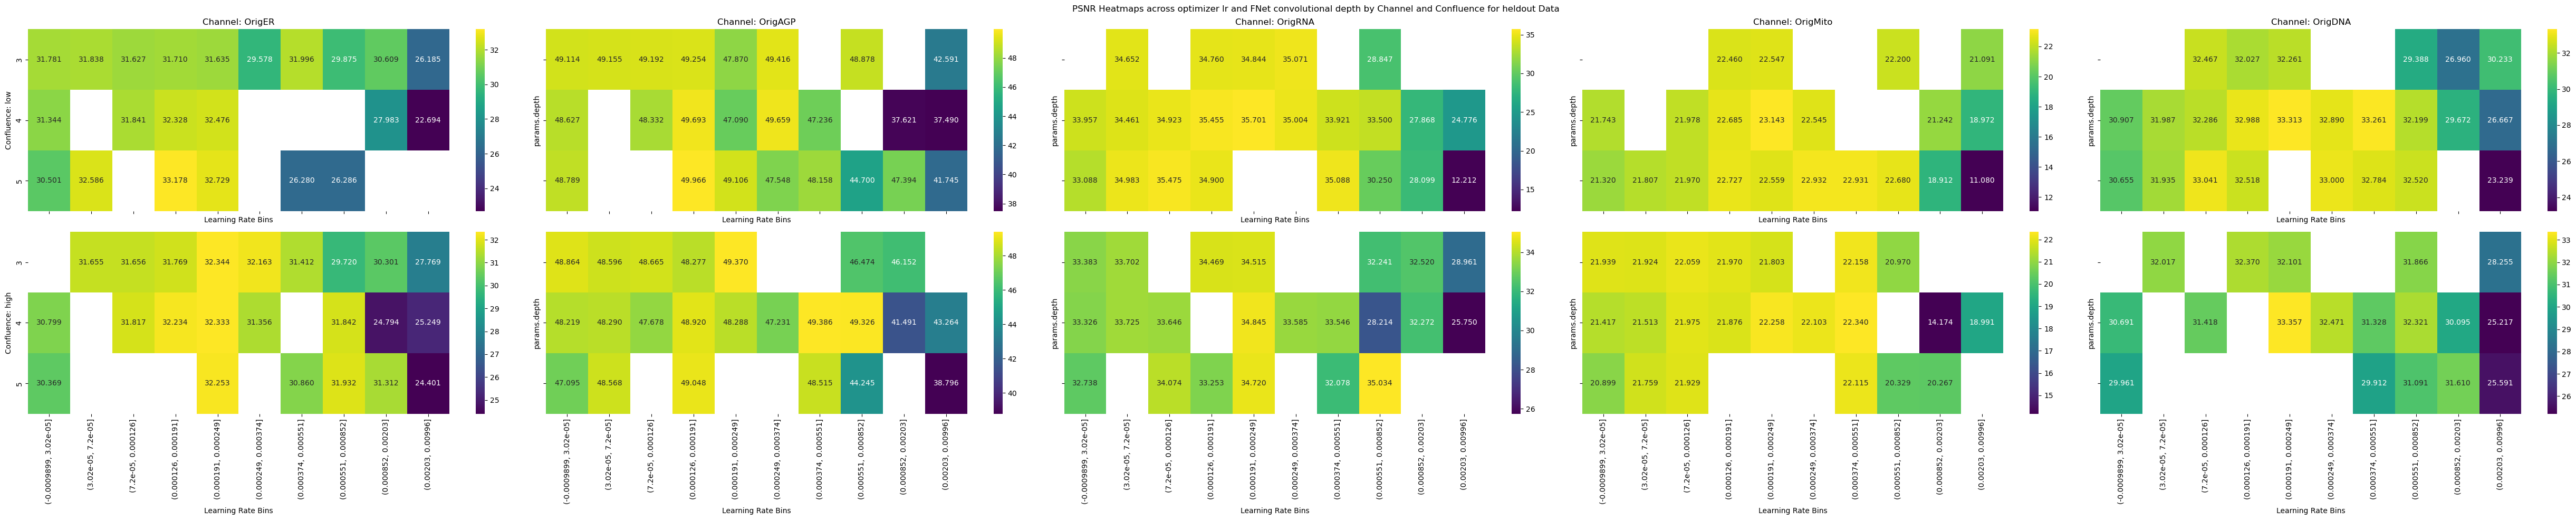

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/tmp/ipykernel_4082072/883144403.py:40: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



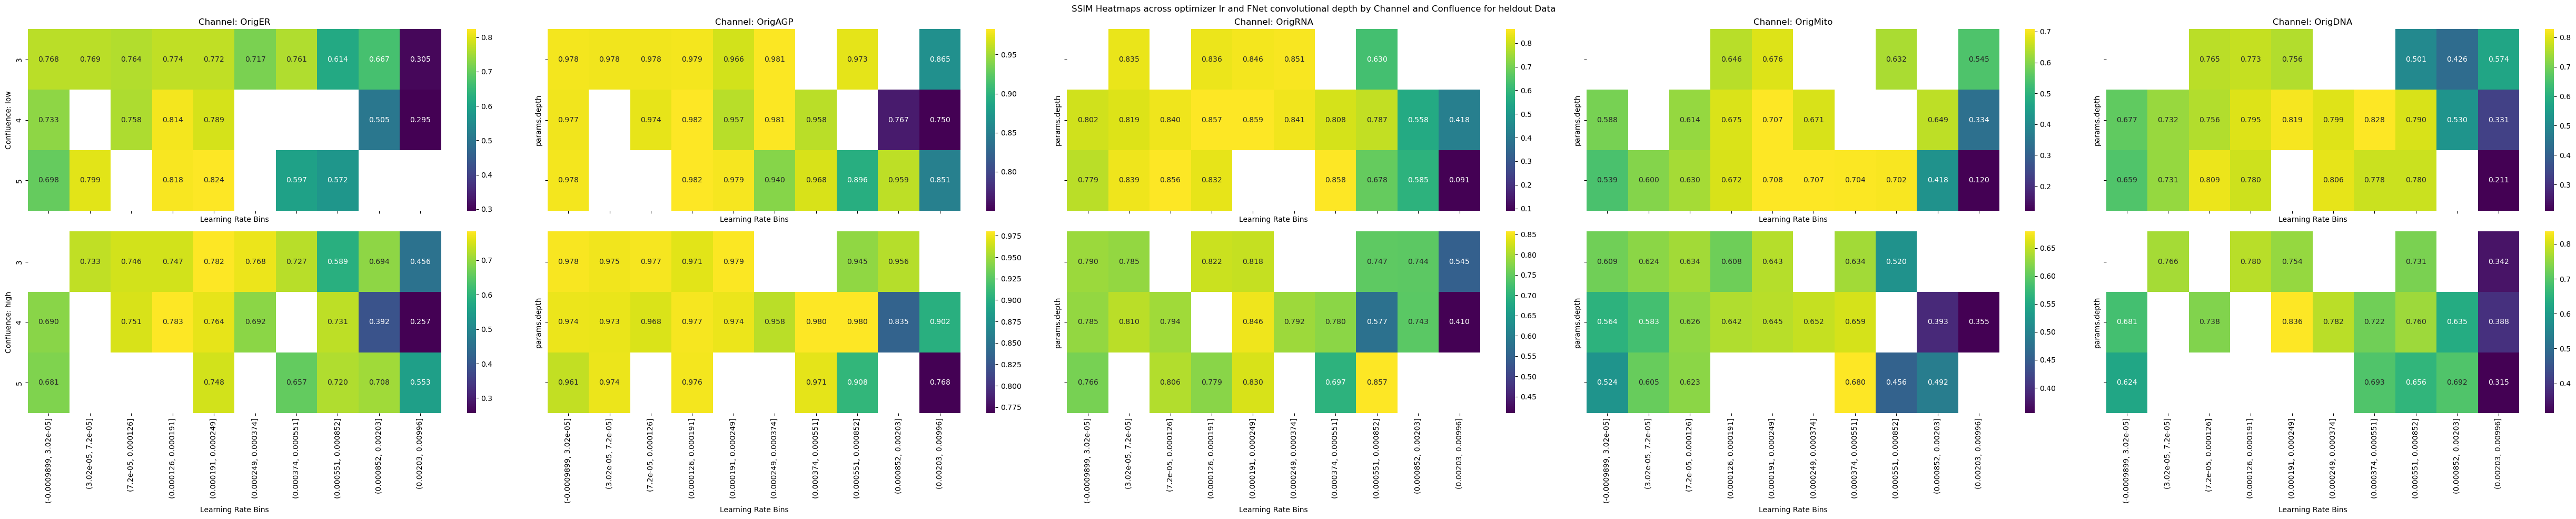

In [13]:
for metric_fn in EVAL_METRICS:

    metric_name = metric_fn.__class__.__name__

    for datasplit in all_metrics_df['datasplit'].unique():

        datasplit_df = all_metrics_df[all_metrics_df['datasplit'] == datasplit].copy()
        datasplit_df["params.lr"] = pd.to_numeric(datasplit_df["params.lr"], errors="coerce")
        datasplit_df = datasplit_df.dropna(subset=["params.lr"])

        # Define binning for params.lr only
        datasplit_df["lr_bin"] = pd.qcut(datasplit_df["params.lr"], q=10, duplicates="drop")

        # Get unique values for subplot arrangement
        channel_names = datasplit_df["params.channel_name"].unique()
        confluence_levels = datasplit_df["confluence"].unique()

        # Determine subplot grid size
        cols = len(channel_names)  # One column per channel_name
        rows = len(confluence_levels)  # One row per confluence

        fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 5 * rows), sharex=True, sharey=True)
        fig.suptitle(f"{metric_name} Heatmaps across optimizer lr and FNet convolutional depth by Channel and Confluence for {datasplit} Data")

        # Ensure axes is a 2D array for consistent indexing
        if rows == 1:
            axes = np.array([axes])  # Convert to 2D array with one row
        if cols == 1:
            axes = np.array([[ax] for ax in axes])  # Convert to 2D array with one column

        # Iterate through unique combinations of (channel_name, confluence) and plot heatmap
        for i, confluence in enumerate(confluence_levels):
            for j, channel in enumerate(channel_names):
                ax = axes[i, j]

                # Filter data for this combination
                subset = datasplit_df[(datasplit_df["params.channel_name"] == channel) & (datasplit_df["confluence"] == confluence)]

                # Create pivot table with integer depth values
                pivot_table = subset.pivot_table(index="params.depth", columns="lr_bin", values=metric_name, aggfunc="mean")

                # Plot heatmap
                sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".3f", ax=ax)

                # Titles and labels
                if i == 0:
                    ax.set_title(f"Channel: {channel}")
                if j == 0:
                    ax.set_ylabel(f"Confluence: {confluence}")
                ax.set_xlabel("Learning Rate Bins")

        plt.tight_layout()
        plt.show()

        # Save the plot
        plot_filename = VALIDATION_OUTPUT_DIR / f"{metric_name}_{datasplit}_heatmap.png"
        fig.savefig(plot_filename)